# Transform DeepMoD interactive effects into $e_{ijt}$ (direction) and $c_{ijt}$ (strength) of interactions from NODEBNGM

In [1]:
# imports
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.gridspec as gridspec
import math

In [2]:
# path of data file
filename = f"miaSim_glv_4species_new.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/final_datasets/"

# function to import the datafile and put it into the right format
def create_data():
    ts_all = []
    data_all = []
    names_all = []
    data = pd.read_csv(f"{filepath}{filename}", sep=",", header=0)
    names = list(data.columns)[1:]
    usol = data.to_numpy()
    ts = usol[:, 0]
    data_y = usol[:, 1:]
    print(f"shape of the dataset", data_y.shape)
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    return ts, data_y, names
    
T, Y, Names = create_data()

shape of the dataset (151, 4)


In [4]:
# Given inputs
n = n_taxa # Number of dimensions
t = T  # Time steps
matrix = Y # x values for each time step

# growth vector g
g = np.array([2/3, -1, 0.7, -3])
# interaction matrix A
A = np.array([
    [-0.5, -15, 0, 0], 
    [10, -0.5, 0, 0], 
    [0, 0, -0.5, -10], 
    [0, 0, 25, -0.5]
])

# directions ($e_{ij}$) and strengths ($c_{ij}$) of interaction as defined for NODEBNGM

$$e_{ijt} = \frac{\partial}{\partial x_i} \frac{d x_i}{dt} , \; e_{ij} = \frac{1}{K} \sum_k e_{ijk}$$
(mean over all time steps)

$$c_{ijt} = \frac{d x_j}{dt} \frac{\partial}{\partial x_i} \frac{d x_i}{dt} , \; c_{ij} = (\sum_{ijk} c_{ijk}^2 )^{-1} \sum_{t} c_{ijt}^2$$
(relative sum of squares)

In [5]:
# Function to compute eij values for a given x, g, and A
def compute_eij(x, g, A):
    n = len(g)
    e = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                e[i,j] = g[i] - x[i] - np.sum(A[i,:] * x)
            else:
                e[i,j] = A[i,j] * x[i] - A[j,i] * x[j]
                
    return e

# Function to compute dx/dt for a given x, g, and A
def dx_dt(x, g, A):
    return g + np.dot(x, A)

In [7]:
# Initialize matrices to store summed values
eij_values_sum = np.zeros((n, n))
c_values = np.zeros((n, n, len(t)))

# Loop over all time steps to compute eij and cij values for each t
for index in range(len(t)):
    x_t = matrix[index, :]       # Extract x values for current time step
    eij_t = compute_eij(x_t, g, A)   # Compute eij for current time step
    
    dx_dt_t = dx_dt(x_t, g, A)   # Compute dx/dt for current time step
    for i in range(n):
        for j in range(n):
            # Compute cijt for current time step using eij and dx/dt values
            c_values[i, j, index] = dx_dt_t[j] * eij_t[i, j]
    eij_values_sum += eij_t      # Accumulate eij values for all t

# Calculate mean eij over all time steps
e_ij = eij_values_sum / len(t)

# Initialize matrix to store the final cij values
c_ij = np.zeros((n, n))

# Loop over all i, j to compute cij values
for i in range(n):
    for j in range(n):
        c_sum_squared = np.sum(c_values[i, j, :] ** 2)
        # Calculate cij using the formula given
        c_ij[i, j] = (np.sum(c_values[:, :, :] ** 2) ** -1) * c_sum_squared

print(e_ij)
print(c_ij)


[[ 1.20265622 -1.93020399  0.          0.        ]
 [ 1.93020399 -2.04536572  0.          0.        ]
 [ 0.          0.          1.25431411 -2.73476496]
 [ 0.          0.          2.73476496 -6.02844608]]
[[0.00164128 0.0296675  0.         0.        ]
 [0.00402544 0.03028415 0.         0.        ]
 [0.         0.         0.01646821 0.15745151]
 [0.         0.         0.08663609 0.67382582]]


[[ 0.   -0.06  0.    0.  ]
 [ 0.01 -0.06  0.    0.  ]
 [ 0.    0.    0.02 -0.43]
 [ 0.    0.    0.24 -4.06]]


<Axes: >

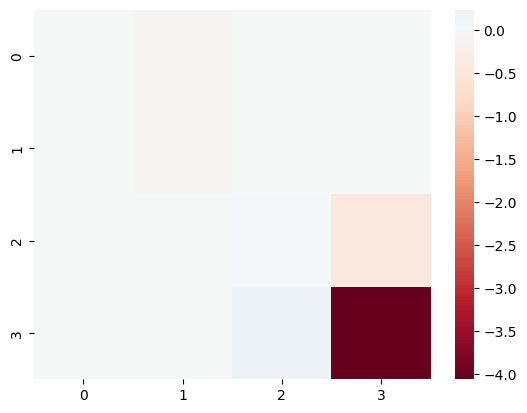

In [16]:
print((e_ij * c_ij).round(2))
sns.heatmap(e_ij * c_ij, center=0, cmap="RdBu")